$\textbf{Propagation Delay Calculation}$

$\text{In this tutorial we will see how to calculate the $t_0$ with the known sample}$

In [1]:
%matplotlib notebook
import os
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt


from pyccapt.calibration import variables, tools, data_tools, mc_tools
from pyccapt.tools.module_dir import MODULE_DIR

# The initial value for flight path length, which is the distance of local electrod to detector 
flightPathLength = 110 # mm
# The initial value for t_0
t0 = 1 # ns

# if you want to save the picture the process takes too long
# For faster run put save_figure to False
save_figure = True

In [2]:
variables.init()

# dataset name
dataset_name = 'AL_data_b'
# dataset_name = 'OLO_AL_6_data'
# dataset_name = 'OLO_W_6_data'

variables.path = os.path.join(os.path.split(os.path.split(MODULE_DIR)[0])[0], 'tests//results//load_crop')
variables.result_path = os.path.join(os.path.split(os.path.split(MODULE_DIR)[0])[0], 'tests/results/t0_calibration/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '_cropped' + '.h5'

head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)
print(data)

dld_highVoltage = data['dld/high_voltage'].to_numpy()
dld_pulseVoltage = data['dld/pulse_voltage'].to_numpy()
dld_startCounter = data['dld/start_counter'].to_numpy()
dld_t = data['dld/t'].to_numpy()
dld_x = data['dld/x'].to_numpy()
dld_y = data['dld/y'].to_numpy()

          dld/high_voltage  dld/pulse_voltage  dld/start_counter       dld/t  \
0              3915.549072        3915.549072            43918.0  702.704970   
1              3915.549072        3915.549072            44007.0  529.471890   
2              3915.549072        3915.549072            44671.0  699.886332   
3              3915.549072        3915.549072            44956.0  708.054210   
4              3915.549072        3915.549072            45618.0  705.605904   
...                    ...                ...                ...         ...   
15292619       7542.105957        7542.105957            28996.0  518.265918   
15292620       7542.105957        7542.105957            29009.0  524.588994   
15292621       7542.105957        7542.105957            29010.0  395.843760   
15292622       7542.105957        7542.105957            29010.0  532.496268   
15292623       7542.105957        7542.105957            29615.0  524.630142   

              dld/x      dld/y  
0     

$\mathbf{\text{calculate the mc in two mode for laser and voltage atom probe:}}$<br><br>
$$\frac{m}{n} = k V_{dc}(\frac{t + t_{0}}{d})^{2} ,$$<br>
$\text{or:}$
$$\frac{m}{n} = k\alpha (V_{dc} + \beta V_{pulse})(\frac{t + t_{0}}{d})^{2} $$<br>

<IPython.core.display.Javascript object>


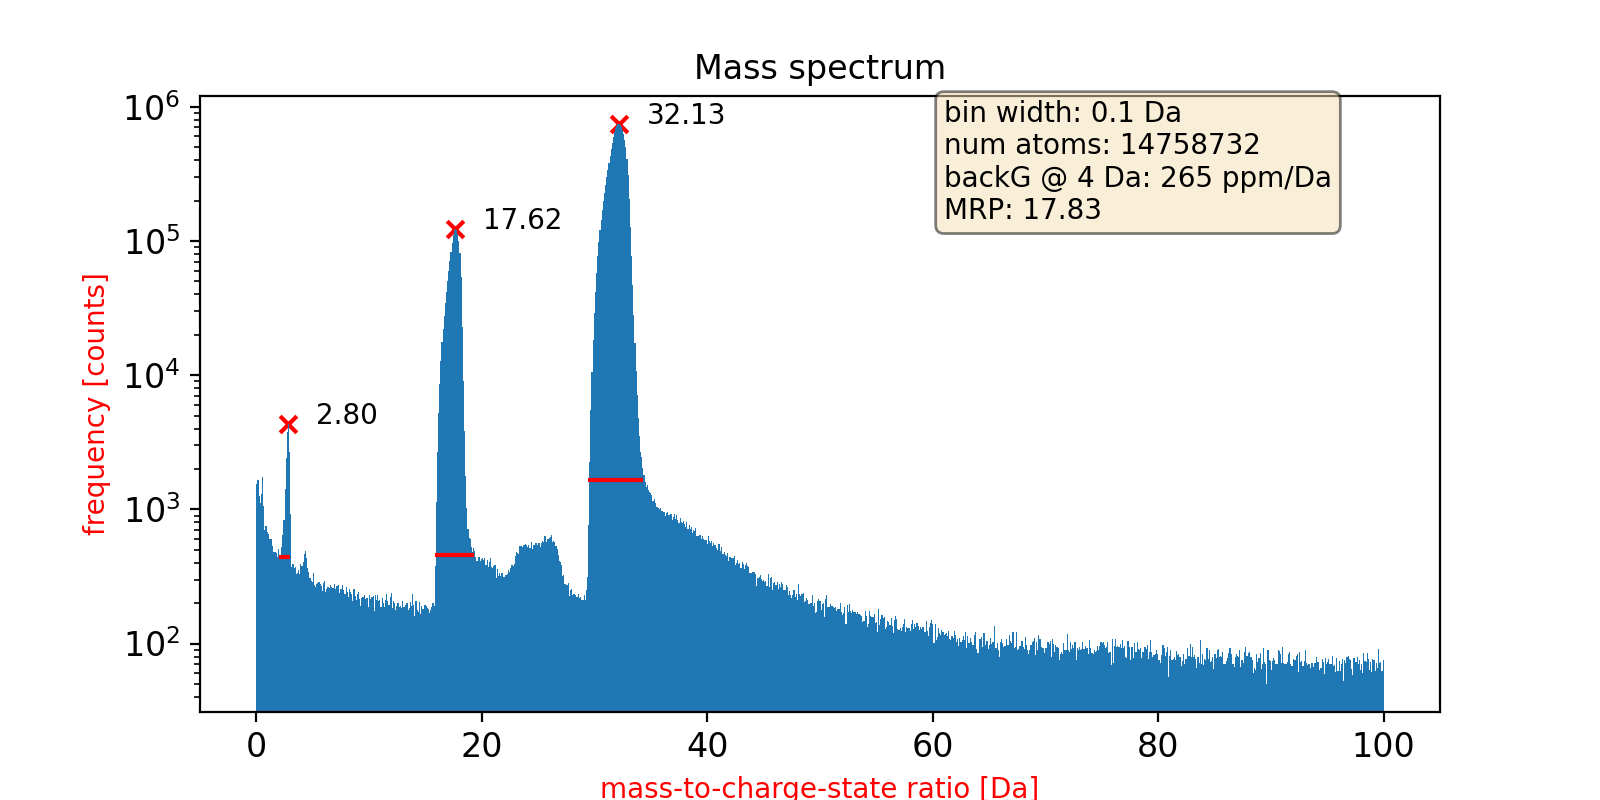

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [17.83333333]
Peaks  0 is: 2.80 peak window sides are: 2.50 - 3.00
Peaks  1 is: 17.62 peak window sides are: 17.02 - 18.12
Peaks  2 is: 32.13 peak window sides are: 31.13 - 32.93


In [3]:
mc_seb = mc_tools.tof2mc(dld_t, t0, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength, mode='voltage_pulse')
max_hist, left_right_peaks, peaks_sides, max_paek_edges = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, fig_name=figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))

$\text{In the cell below you should type the correct m/c for the detected peak above}$

In [4]:
peak_ideal = [1.01, 13.49, 26.98]

$\text{Here for each peak a mask will be created}$

In [5]:
pick_ions_plot = []

# creat mask for each peak base on the peak loc. and window size
for i in range(len(peaks_sides)):
    mask_tmp = np.logical_and((peaks_sides[i, 2] < mc_seb), (mc_seb < peaks_sides[i, 3]))
    if i == 0:
        lenght = len(mask_tmp[mask_tmp==True])

        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()
    else:    
        indexes_mask_tmp_equal = np.where(mask_tmp==True)[0].tolist()    
        indexes_mask_tmp_equal = np.random.choice(indexes_mask_tmp_equal, size=lenght, replace=False)
    
    
    bb = np.zeros(len(mc_seb))
    
    mc_seb_ideal_tmp = np.copy(bb)
    # put the location (mc) of the peak for all selected mc
    mc_seb_ideal_tmp[mask_tmp] = peak_ideal[i]
    
    pick_ions_plot.append(mask_tmp)
    if i == 0:
        mask = np.copy(mask_tmp)
        mc_seb_ideal = np.copy(mc_seb_ideal_tmp)
        mask_equal = indexes_mask_tmp_equal
    else:
        mask += mask_tmp
        mc_seb_ideal += mc_seb_ideal_tmp 
        mask_equal.extend(indexes_mask_tmp_equal)

$\text{The selcted peak ions in shown below}$

<IPython.core.display.Javascript object>


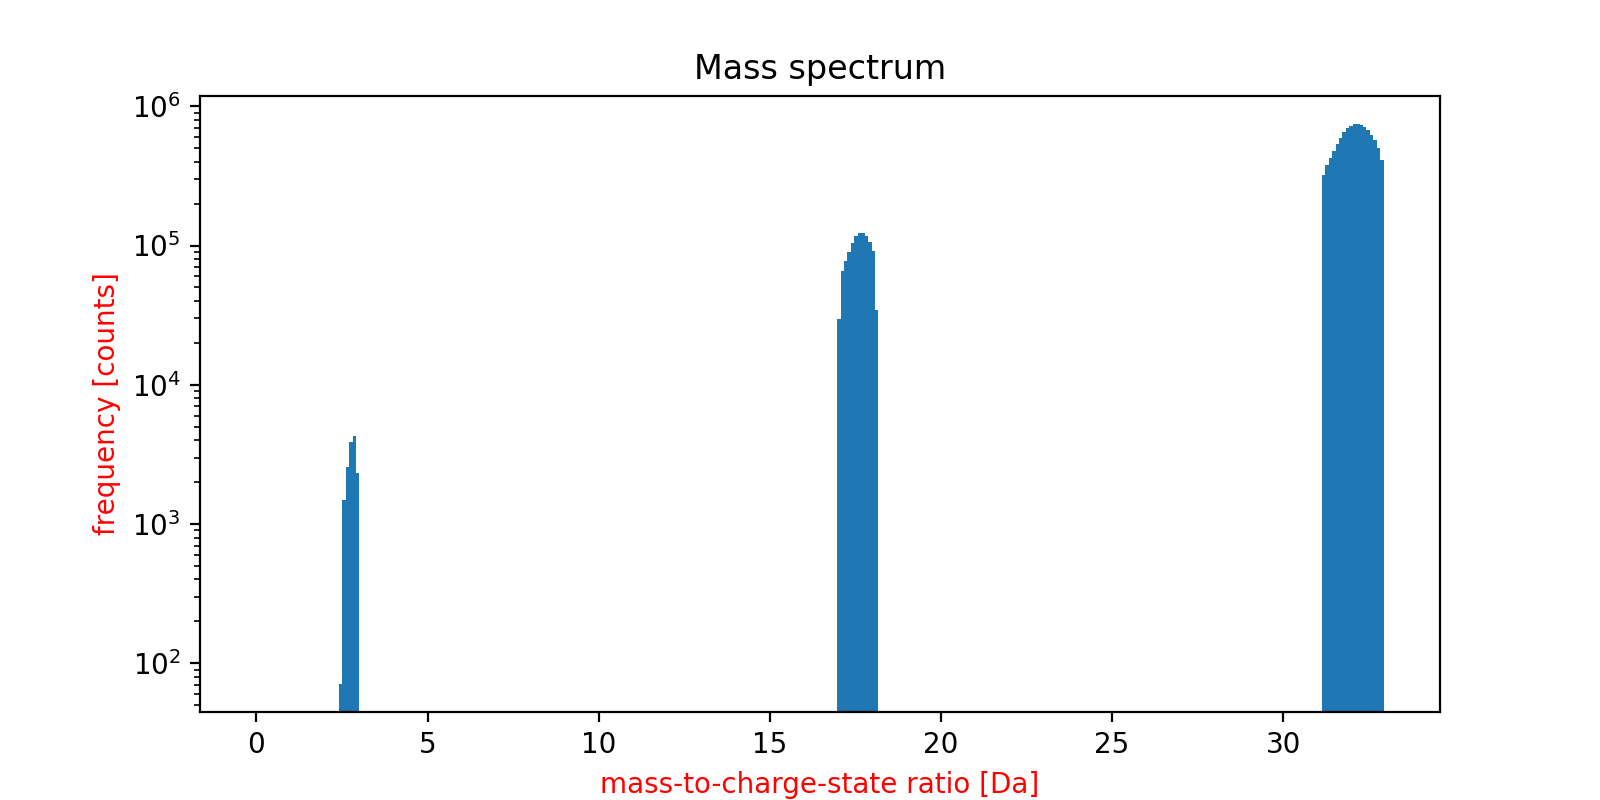

(0, 0, 0, 0)

In [6]:
mc_seb_masked = mc_seb[mask]
tools.massSpecPlot(mc_seb_masked[mc_seb_masked < 100], 0.1, peaks_find=False, plot=True)

$\text{Plot ideal peak m/c:}$

<IPython.core.display.Javascript object>


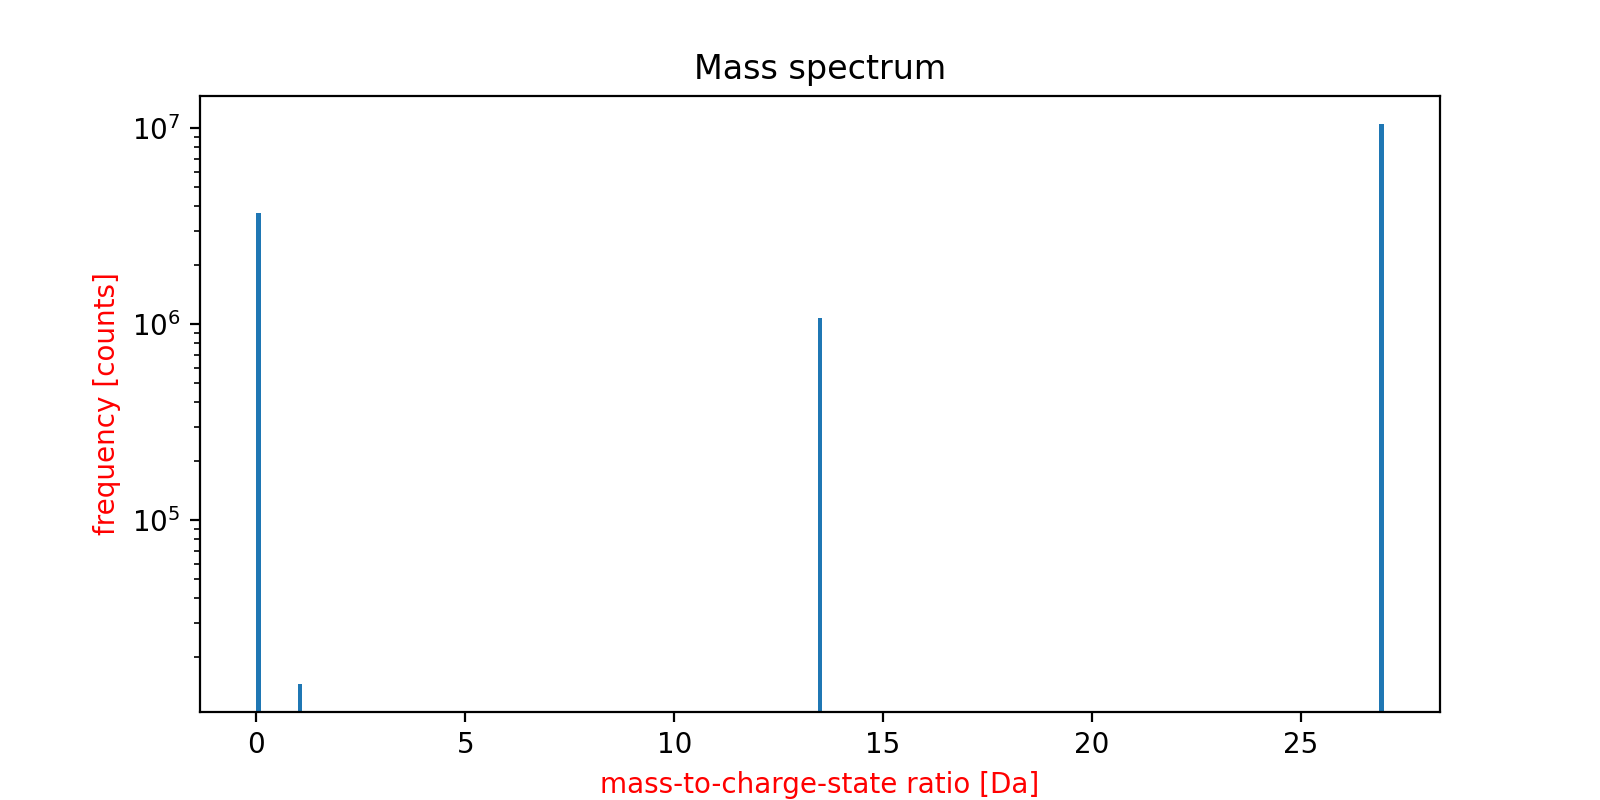

(0, 0, 0, 0)

In [7]:
tools.massSpecPlot(mc_seb_ideal, 0.1, peaks_find=False, plot=True)

$\text{Here we plot ions in each peak base on the TOF and (x,y) position}$

<IPython.core.display.Javascript object>


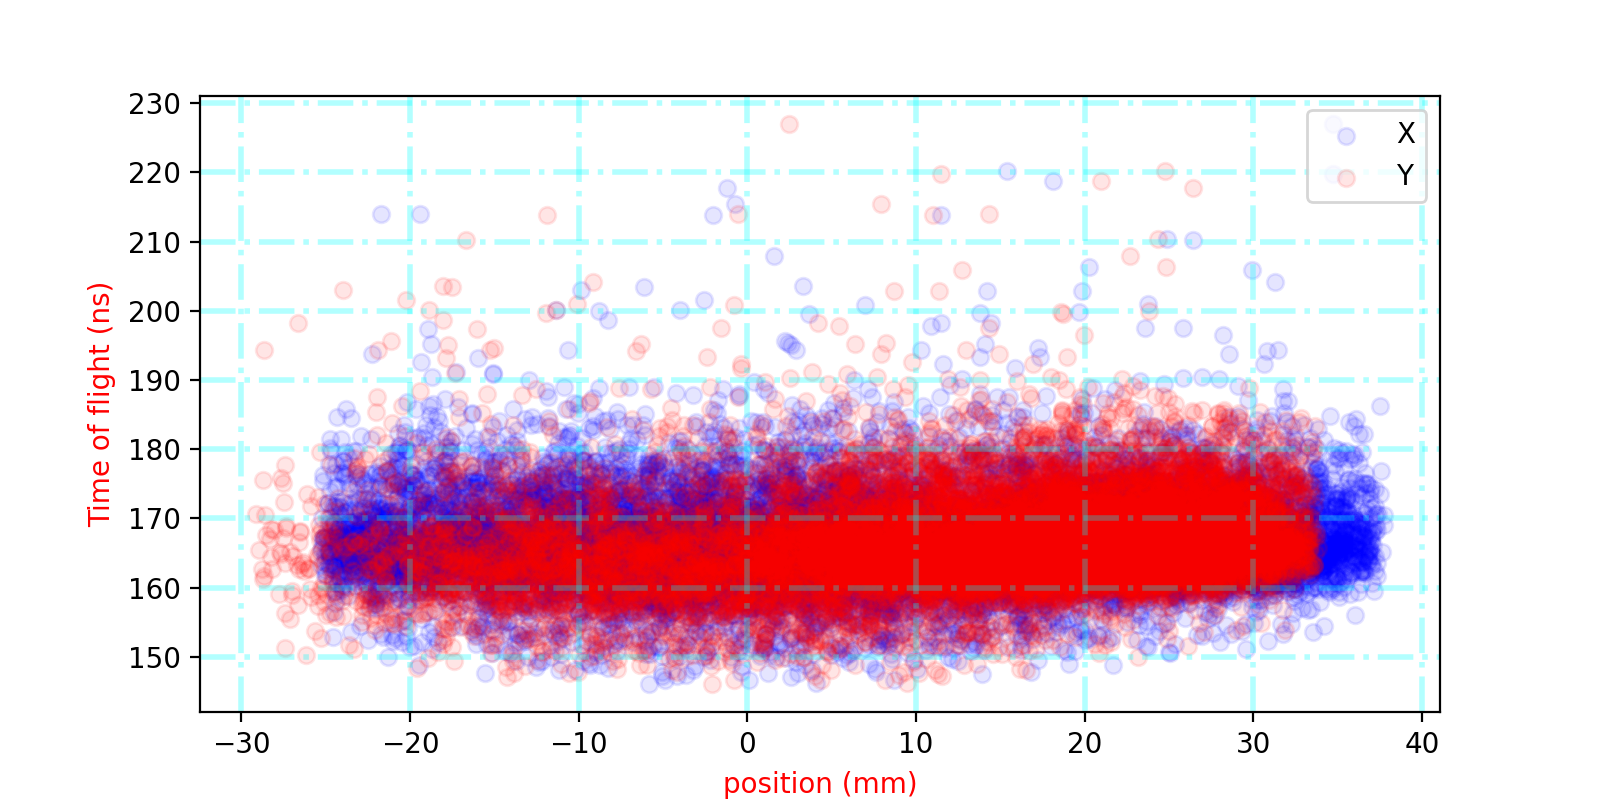

<IPython.core.display.Javascript object>


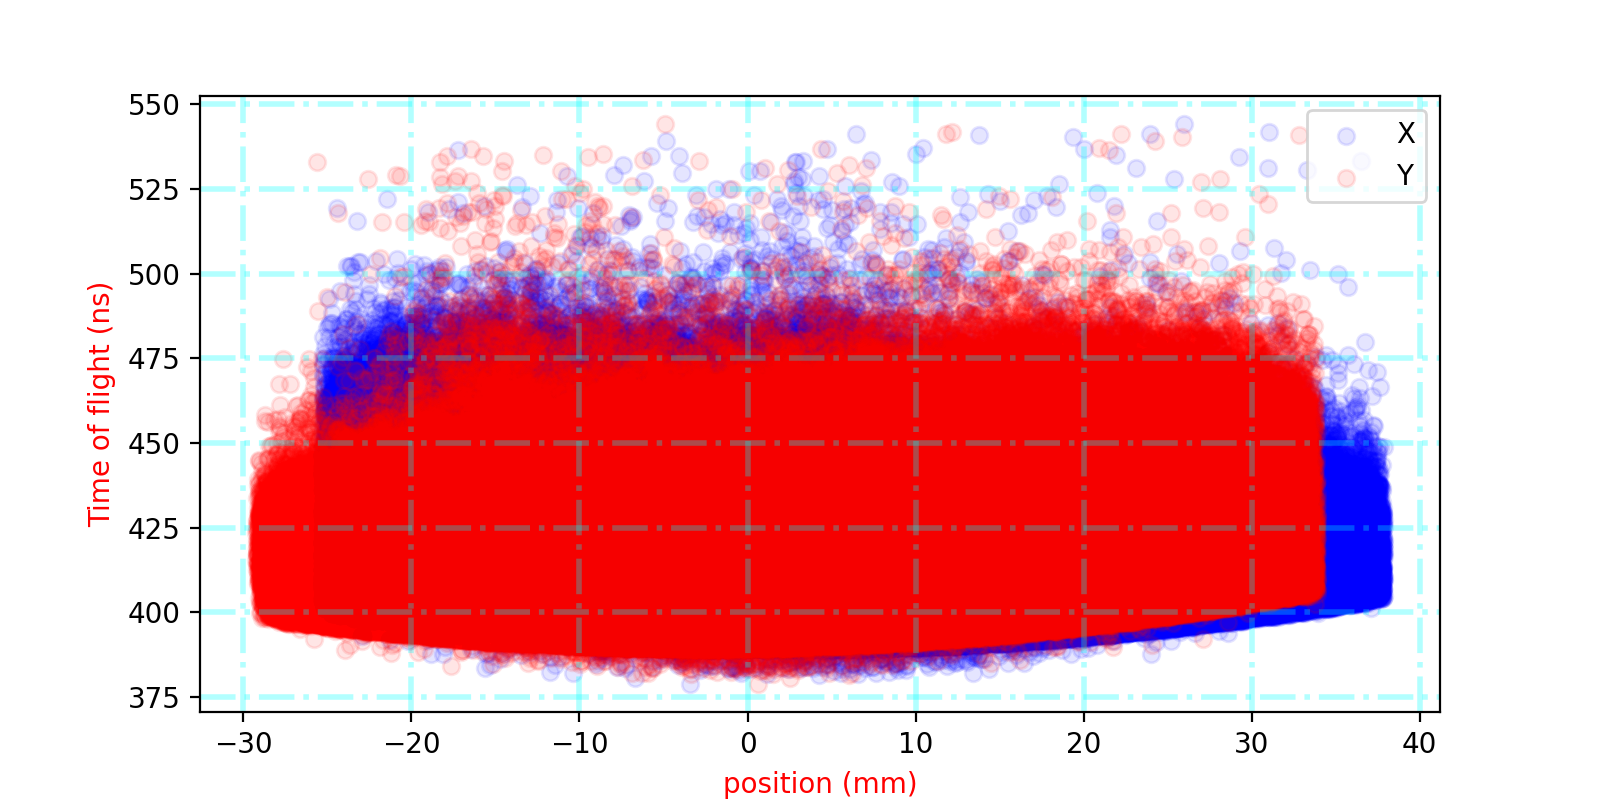

<IPython.core.display.Javascript object>


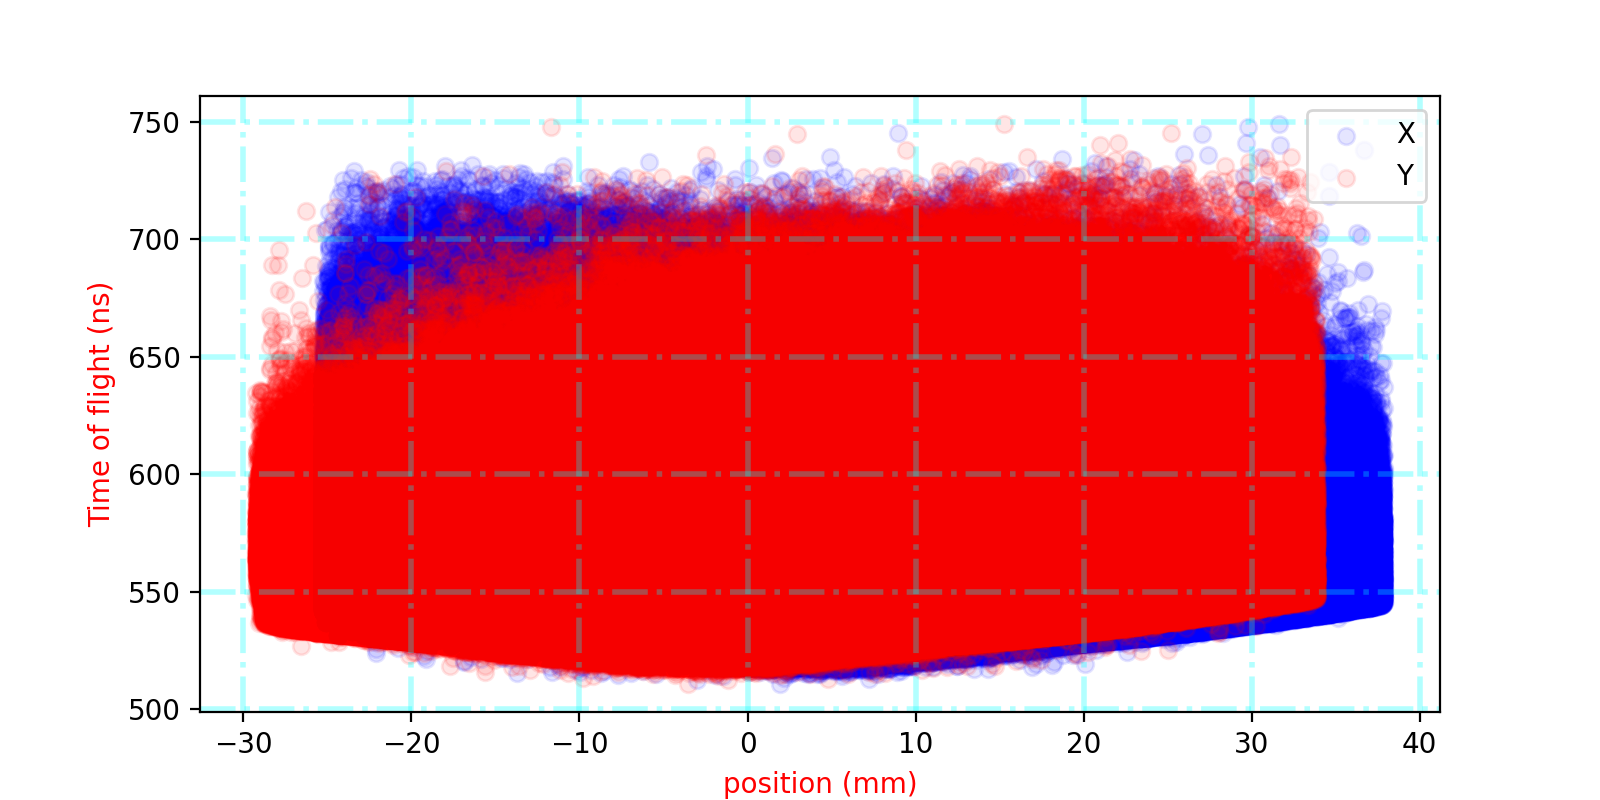

In [9]:
for i in range(len(pick_ions_plot)):
    fig1, ax1 = plt.subplots(figsize=(8, 4))
    dld_x_masked = dld_x[pick_ions_plot[i]]
    dld_y_masked = dld_y[pick_ions_plot[i]]
    dld_t_masked = dld_t[pick_ions_plot[i]]
    x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
    y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
    ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
    ax1.set_xlabel("position (mm)", color="red", fontsize=10)
    plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
    plt.legend(handles=[x, y], loc='upper right')
#     if save_figure == True:
#         plt.savefig(variables.result_path + '/position_peak_%s' %i + "%s.png" %figname, format="png", dpi=600)
    plt.show()

$\text{As you saw the TOF changes base on the (x,y) of the events. Therefore we creat a mask to only select the ions in center (4mm*4mm) of detector. This helps to cansel out the variation in TOF due to hit position}$

$\text{Reformulate the equation for volatege atom probe:}$<br>
$$t = d(\sqrt{\frac{\frac{m}{n}}{k\alpha (V_{dc}+\beta V_{pulse})}})-t_{0} $$<br>

<IPython.core.display.Javascript object>


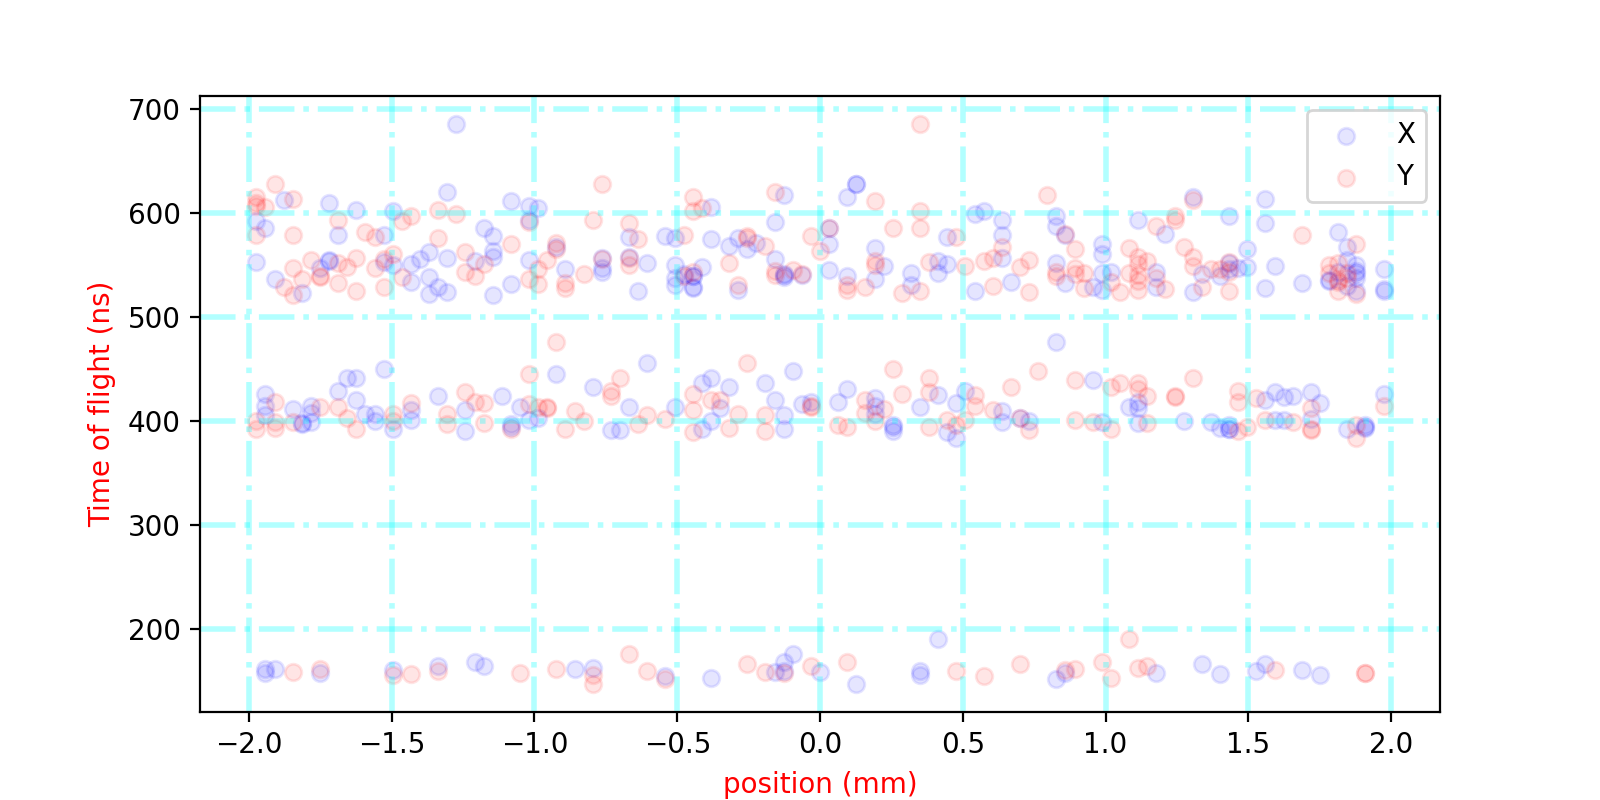

(265,)


In [10]:
# use mask_equal to have equal number of ions for each peak
# only peak the value in the center of detector 2mm * 2mm
detector_squre = 2
fig1, ax1 = plt.subplots(figsize=(8, 4))
dld_x_masked = dld_x[mask_equal]
dld_y_masked = dld_y[mask_equal]
dld_t_masked = dld_t[mask_equal]
dld_highVoltage_masked = dld_highVoltage[mask_equal]

mask_tmp_middle = np.logical_and((np.abs(dld_x_masked) < detector_squre), (np.abs(dld_y_masked) < detector_squre))
dld_x_masked = dld_x_masked[mask_tmp_middle]
dld_y_masked = dld_y_masked[mask_tmp_middle]
dld_t_masked = dld_t_masked[mask_tmp_middle]
dld_highVoltage_masked = dld_highVoltage_masked[mask_tmp_middle]

mc_seb_reg_masked = mc_seb_ideal[mask_equal]
mc_seb_reg_masked = mc_seb_reg_masked[mask_tmp_middle]

print(dld_t_masked.shape)
x = plt.scatter(dld_x_masked, dld_t_masked, color="blue", label='X', alpha=0.1)
y = plt.scatter(dld_y_masked, dld_t_masked, color="red", label='Y', alpha=0.1)
ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=10)
ax1.set_xlabel("position (mm)", color="red", fontsize=10)
plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[x, y], loc='upper right')
if save_figure == True:
    plt.savefig(variables.result_path + '/center_' + "%s.png" %figname, format="png", dpi=600)
#     plt.savefig(variables.result_path + '/center_' + "%s.svg" %figname, format="svg", dpi=600)
plt.show()


$\text{We calculate the t_0 base on:}$<br>
$$t_{0} = \frac{\sum_{n=1}^n{\left (t - L_{flight}  \sqrt{\frac{m/n}{2eV}} \right )}}{n}$$<br>

In [11]:
seb_t = dld_t_masked * 1E-9  # tof in s
# seb_factor = np.sqrt(mc_seb_reg_ideal[mask_middle] * 1.66E-27 / (2 * 1.6E-19 * 1.015 * (dld_highVoltage_masked + 0.7 * dld_pulseVoltage_masked)))
seb_factor = np.sqrt(mc_seb_reg_masked * 1.66E-27 / (2 * 1.6E-19 * dld_highVoltage_masked))

seb_factor = seb_factor * 1E6
seb_t = seb_t * 1E9

t0_seb_fixed = np.mean(np.array([seb_t]).squeeze(0) - (110 * np.array([seb_factor]).squeeze(0).reshape(-1, 1)))
print('Linear fixed path lenght -- the flight path lenght(slop): {:.2f}'.format(110), '(mm)', '\nthe corrected t_0(intercept): {:.2f}'.format(t0_seb_fixed), '(ns)')


Linear fixed path lenght -- the flight path lenght(slop): 110.00 (mm) 
the corrected t_0(intercept): 51.74 (ns)


In [12]:
t0_new = t0_seb_fixed

<IPython.core.display.Javascript object>


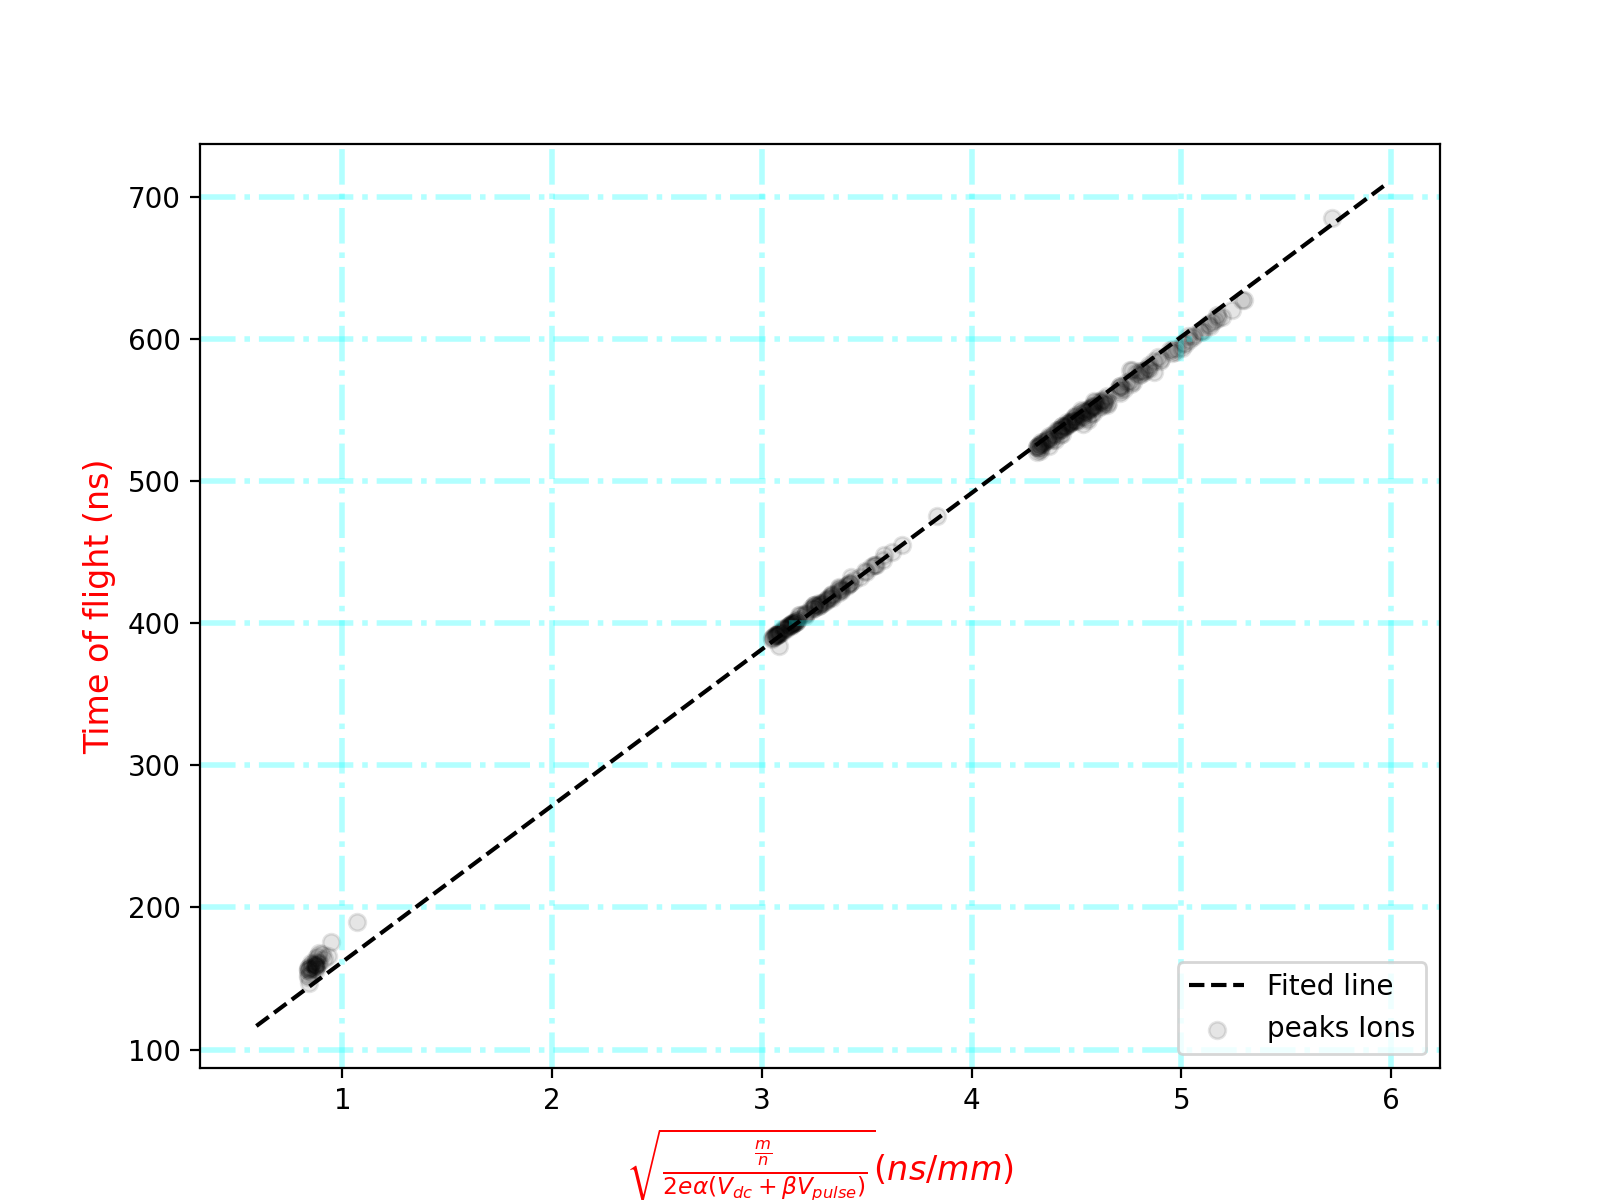

In [13]:
# Plot outputs
fig1, ax1 = plt.subplots(figsize=(8, 6))
peaks_data = plt.scatter(seb_factor, seb_t, color="black", label='peaks Ions', alpha=0.1)
axes = plt.gca()
x_vals = np.array(axes.get_xlim())

linear_fix, = plt.plot(x_vals, t0_seb_fixed + 110 * x_vals, '--', color='black', label='Fited line' )

plt.grid(color='aqua', alpha=0.3, linestyle='-.', linewidth=2)
plt.legend(handles=[linear_fix, peaks_data], loc='lower right')

ax1.set_ylabel("Time of flight (ns)", color="red", fontsize=12)

ax1.set_xlabel(r"$\sqrt{\frac{\frac{m}{n}}{2e \alpha (V_{dc} + \beta V_{pulse})}} (ns/mm)$", color="red", fontsize=12)
if save_figure == True:
    plt.savefig(variables.result_path + '/regression' + "%s.svg" %figname, format="svg", dpi=600)
    plt.savefig(variables.result_path + '/regression' + "%s.png" %figname, format="png", dpi=600)
plt.show()

$\text{Plot the m/c with new ${t_0}$ :}$<br>

<IPython.core.display.Javascript object>


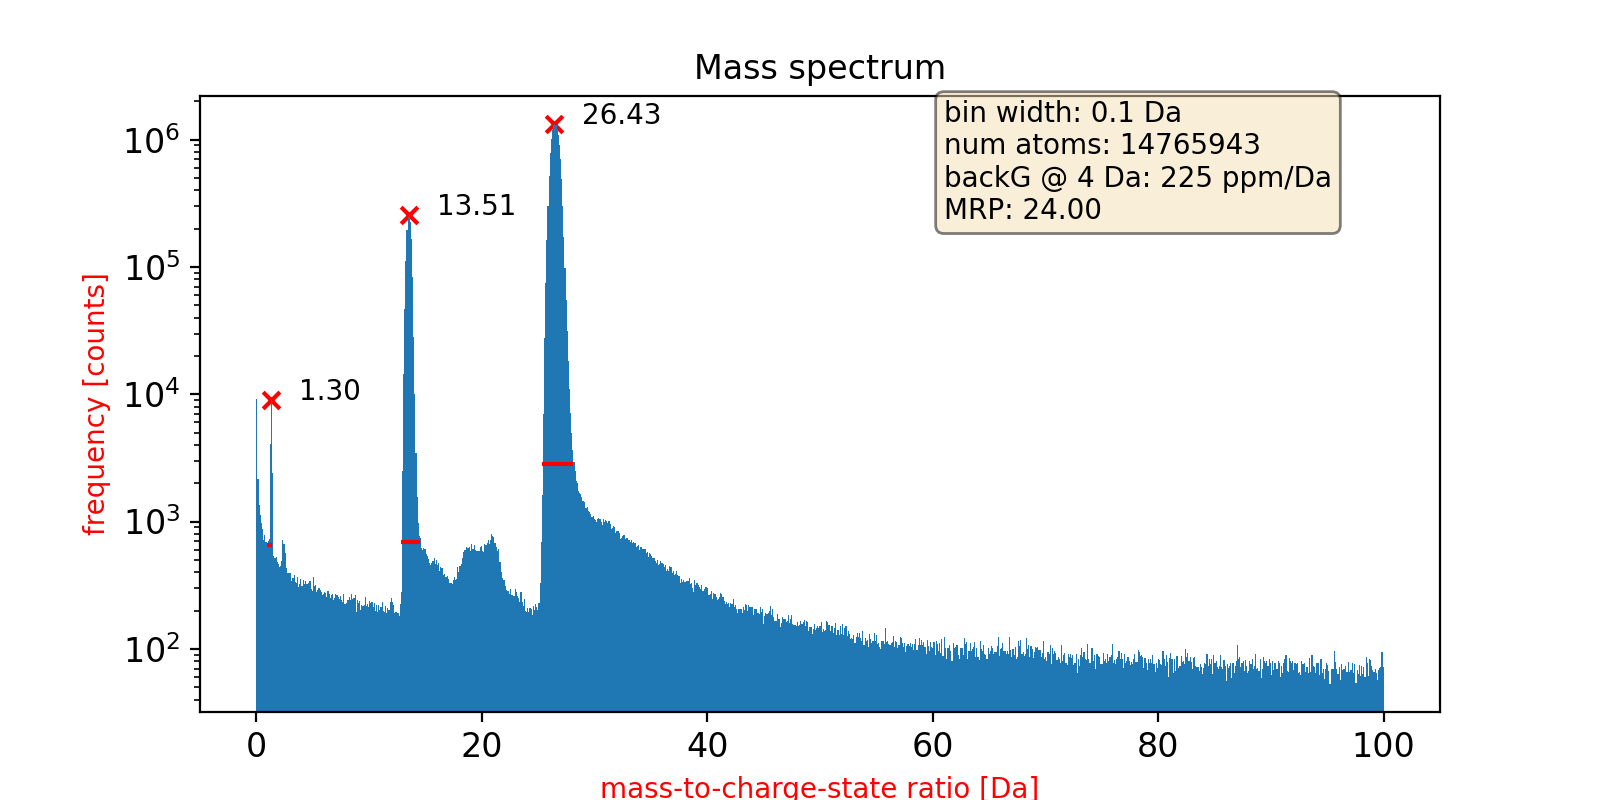

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [24.]
Peaks  0 is: 1.30 peak window sides are: 1.20 - 1.40
Peaks  1 is: 13.51 peak window sides are: 13.21 - 13.81
Peaks  2 is: 26.43 peak window sides are: 25.92 - 27.03


In [14]:
# calculate the mc with new flight path lenght and t_0
mc_seb = mc_tools.tof2mc(dld_t, t0_new, dld_highVoltage, dld_pulseVoltage, dld_x, dld_y, flightPathLength)

max_hist, left_right_peaks, peaks_sides, max_paek_edges = tools.massSpecPlot(mc_seb[mc_seb < 100], 0.1, percent=50, plot=True, prominence=500, distance=None, fig_name='corrected_'+figname)
mrp = (max_hist / (left_right_peaks[1] - left_right_peaks[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
for i in range(len(peaks_sides)):
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides[i,2], peaks_sides[i,3]))